# Testing GISSR-style inundation on ideal topo

Imports and setups

In [1]:
import pandas as pd
import numpy as np

import params_ideal as params

from fun_ideal import calc_flood_height, generate_groups, calc_group_vol, calc_group_h
from ideal_damage import Damage
from topo_ideal import Topo

In [2]:
topo_file = "Input/ideal_topo_gp_points_1.csv"
storm_file = "SurgeData/surge_w.csv"
div_data_file = "Input/ideal_div_data.csv"
time_file = "SurgeData/time_w.csv"
damage_table_file = "Input/damage_table.csv"

In [3]:
surge = pd.read_csv(storm_file).values
surge_time = pd.read_csv(time_file).values
damage_table = pd.read_csv(damage_table_file)


Topo = Topo(topo_file=topo_file)
Damage = Damage(damage_table_file)

In [4]:
# generate groups
#groups = generate_groups(Topo.div_data)

segment_l = 100
wall_height = np.zeros(Topo.shore_height.size)


# Calculate indundation with varying sized walls
Equal height wall for all divs in divs_allocate

In [22]:
divs_allocate = [1]
groups = generate_groups(Topo.div_data)

positions = []
for i, p in enumerate(wall_height):
    if Topo.all_divs[i] in divs_allocate:
        positions.append(i)
        
h_start = 0
h_end = 1
h_num = 3

points = []
wall_height[positions] = h_start

for h in np.linspace(h_start, h_end, num=h_num):
    wall_height[:] = 0
    wall_height[positions] = h

    height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_height, positions)

    # calculate group volumes
    volume_grouped = calc_group_vol(groups, volume_div)

    # get height in each group
    surge_peak = np.amax(surge, axis=1)
    height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)

    #Damage
    dmg = Damage.calc_damage(height_grouped)
    cost_dmg = np.sum(dmg)
    cost_wall = np.sum(49212 * wall_height * segment_l)
    cost_tot = cost_dmg + cost_wall

    points.append([h, cost_wall, cost_dmg, cost_tot, volume_div[4,1]])
    print(height_div)

    
df = pd.DataFrame(points)
df.to_csv("Output/single_section_varying_wall.csv")
#print(df)

[[ 4.50854578  5.08462606  4.20254228  4.94841218  5.09432191  5.67015333
   3.73776307  0.79172037  0.77261331  1.04221531  3.59026201  2.35708732
   2.37556657  1.60130317  2.35636302  2.96483479  4.97258743  4.03626121]
 [ 0.28807437  0.3258488   0.28807437  0.33263963  0.33263963  0.33263963
   0.23521174  0.          0.          0.          0.16631981  0.
   0.          0.          0.          0.          0.28807437  0.21605994]
 [ 0.23389083  0.26304506  0.23389083  0.27007387  0.27007387  0.27007387
   0.19097107  0.          0.          0.          0.13503694  0.
   0.          0.          0.          0.          0.23389083  0.16806562]
 [ 4.05097162  4.55842132  3.77004011  4.44005428  4.58244429  5.04609091
   3.3470209   0.56827239  0.45555759  0.72599343  3.16872623  1.90299896
   1.85428143  1.00071318  1.98306307  2.53813971  4.41312728  3.59320879]
 [ 1.96195534  2.21774922  1.85748597  2.14668965  2.23587203  2.27976633
   1.57721334  0.          0.          0.         

# Inundation with varying travel distance for redistribution

In [13]:
divs_allocate = list(range(18))

positions = []
for i, p in enumerate(wall_height):
    if Topo.all_divs[i] in divs_allocate:
        positions.append(i)
        
h_start = 0
h_end = 0
h_num = 1

points = []
wall_height[positions] = h_start

data = []
for r in range(18):
    params.travel_dist = r
    groups = generate_groups(Topo.div_data)

    for h in np.linspace(h_start, h_end, num=h_num):
        wall_height[:] = 0
        wall_height[positions] = h

        height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_height, positions)

        # calculate group volumes
        volume_grouped = calc_group_vol(groups, volume_div)

        # get height in each group
        surge_peak = np.amax(surge, axis=1)
        height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)
        
        #Damage
        dmg = Damage.calc_damage(height_grouped)
        cost_dmg = np.sum(dmg)
        cost_wall = np.sum(49212 * wall_height * segment_l)
        cost_tot = cost_dmg + cost_wall

        points.append([h, cost_wall, cost_dmg, cost_tot])

        data.append(height_grouped[4])
        #print(np.max(np.max(height_grouped, axis=1) - np.min(height_grouped, axis=1)))

df = pd.DataFrame(data)
df.to_csv("Output/ideal_test_travel.csv")

# PLOT


In [14]:
print(df)

          0         1         2         3         4         5         6   \
0   1.961955  2.155053  1.857486  2.146690  2.155053  2.155053  1.577213   
1   2.093762  2.018079  2.079819  2.086277  2.155053  2.056215  1.600514   
2   2.018079  2.050988  2.089274  2.152831  2.036791  1.859695  1.592737   
3   2.050988  2.089274  2.122211  2.053230  1.914643  1.721403  1.571730   
4   2.089274  2.122211  2.053230  1.920621  1.810779  1.688556  1.589237   
5   2.122211  2.053230  1.920621  1.810779  1.717855  1.692195  1.594263   
6   2.053230  1.920621  1.810779  1.717855  1.692195  1.628079  1.564230   
7   1.920621  1.810779  1.717855  1.692195  1.628079  1.564230  1.507330   
8   1.810779  1.717855  1.692195  1.628079  1.564230  1.507330  1.457328   
9   1.717855  1.692195  1.628079  1.564230  1.507330  1.457328  1.433882   
10  1.692195  1.628079  1.564230  1.507330  1.457328  1.433882  1.474505   
11  1.628079  1.564230  1.507330  1.457328  1.433882  1.474505  1.489973   
12  1.564230

We can see below that as the travel distance is increased the water level becomes more and more homogenous

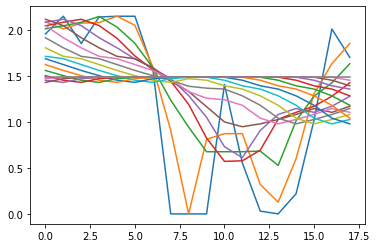

In [15]:
import matplotlib.pyplot as plt

divs = list(range(18))
for div in divs:
    plt.plot(divs, data[div], label=div)
#plt.legend()
plt.show()